# Loading Data and Importing Libraries

This project was made in a python 3.10.11 Env. To get replicatable results from this document, please use python 3.10.11. Any version above this will cause the ROC AUC to be slighlty different, although very similar in results.

In [1]:
# Importing functions and Libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Set a random see of 42.
seed = 42
np.random.seed(seed)

In [2]:
# Loading in our dataset and checking to see if it loaded correctly.
train = pd.read_csv('data.csv')
train.columns = train.columns.str.strip()
display(train.head())
train.head()
print(f"Shape of training data: {train.shape}")

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


Shape of training data: (6819, 96)


# Data Preprocessing

In [3]:
# We store missing values and print out any values with missing values since the amount of
# values we have is too long to display normally.
missing_values = train.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


In [4]:
# Checking Class balancing, so between Bankrupted companies and non-bankrupted companies
# in our dataset.
class_balance = train['Bankrupt?'].value_counts(normalize=True) * 100
print(class_balance)

Bankrupt?
0    96.77372
1     3.22628
Name: proportion, dtype: float64


Unfortunately our data class balancing is severely unbalanced, so we must take this into account. 

In [5]:
# Separate features (X) and target (y)
X = train.drop('Bankrupt?', axis=1)
y = train['Bankrupt?']

In [6]:
# Split into training and testing sets (70/30 split, stratified, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Total samples: {len(X)}")
print(f"\nTraining Set Samples: {len(X_train)} (Bankrupt: {y_train.sum()})")
print(f"Testing Set Samples: {len(X_test)} (Bankrupt: {y_test.sum()})")

Total samples: 6819

Training Set Samples: 4773 (Bankrupt: 154)
Testing Set Samples: 2046 (Bankrupt: 66)


In [7]:
# Fitting into a preliminary Random Forest model to calculate feature importance.
# We use 'balanced' class_weight to ensure importance calculation is not biased by the majority class
# since our classes are very unbalanced.
selector_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
selector_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [8]:
# Select features based on importance
# SelectFromModel keeps features whose importance is greater than the mean importance
# It learned which features are important due to our Random Forest Model from above.
sfm = SelectFromModel(selector_model, threshold='mean', prefit=True)
sfm.fit(X_train, y_train)

,estimator,RandomForestC...ndom_state=42)
,threshold,'mean'
,prefit,True
,norm_order,1
,max_features,None
,importance_getter,'auto'
,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1


In [9]:
# Transform the training and testing sets
X_train_reduced = sfm.transform(X_train)
X_test_reduced = sfm.transform(X_test)

In [10]:
# Get the names of the selected features
selected_feature_indices = sfm.get_support(indices=True)
selected_feature_names = X.columns[selected_feature_indices]

print(f"Original number of features: {X_train.shape[1]}")
print(f"Reduced number of features: {X_train_reduced.shape[1]}")
print("\nSelected Features:")
print(selected_feature_names.to_list())

Original number of features: 95
Reduced number of features: 26

Selected Features:
['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Persistent EPS in the Last Four Seasons', 'Per Share Net profit before tax (Yuan ¥)', 'Net Value Growth Rate', 'Quick Ratio', 'Interest Expense Ratio', 'Total debt/Total net worth', 'Debt ratio %', 'Net worth/Assets', 'Borrowing dependency', 'Net profit before tax/Paid-in capital', 'Current Liabilities/Equity', 'Retained Earnings to Total Assets', 'Total income/Total expense', 'Current Liability to Equity', 'Net Income to Total Assets', "Net Income to Stockholder's Equity", 'Liability to Equity', 'Degree of Financial Leverage (DFL)', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Equity to Liability']


After selecting features only above the mean threshold, we can see that we have significantly dropped our number of features from 95 to 28. This will let us create our model with only features that have a measurable impact on the model’s predictive performance, removing noise and reducing unnecessary complexity within our model.

In [11]:
# Define the feature set for the final modeling
X_final = X_train_reduced
y_final = y_train
X_test_final = X_test_reduced

# Defining Our Model

In [12]:
# Initialize our Random Forest model
# Setting random_state=42 ensures we get the same results each time we run the model
rf_clf = RandomForestClassifier(random_state=42)

In [13]:
# StratifiedKFold is essential for CV with imbalanced data
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [14]:
# Defining the hyperparameter grid for our Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': [np.sqrt(X_final.shape[1]).astype(int), X_final.shape[1]],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 5],
    'class_weight': ['balanced']
}

In [15]:
# Run GridSearchCV to find the best hyperparameters for our Random Forest
grid_search = GridSearchCV(
    estimator=rf_clf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv_strategy,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_final, y_final)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'class_weight': ['balanced'], 'max_depth': [10, 20, ...], 'max_features': [np.int64(5), 26], 'min_samples_leaf': [1, 5], ...}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,300


In [16]:
# Extract the best Random Forest model found during Grid Search and displaying the Hyperparameters we will be using.
best_rf = grid_search.best_estimator_
print("\nBest Hyperparameters Found:")
print(grid_search.best_params_)
print(f"Best ROC AUC Score on CV: {grid_search.best_score_:.4f}")


Best Hyperparameters Found:
{'class_weight': 'balanced', 'max_depth': 20, 'max_features': np.int64(5), 'min_samples_leaf': 1, 'n_estimators': 300}
Best ROC AUC Score on CV: 0.9377


In [17]:
# Generate predictions and the probability scores needed for ROC AUC
y_pred = best_rf.predict(X_test_final)
y_probability = best_rf.predict_proba(X_test_final)[:, 1]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1980
           1       0.48      0.30      0.37        66

    accuracy                           0.97      2046
   macro avg       0.73      0.65      0.68      2046
weighted avg       0.96      0.97      0.96      2046



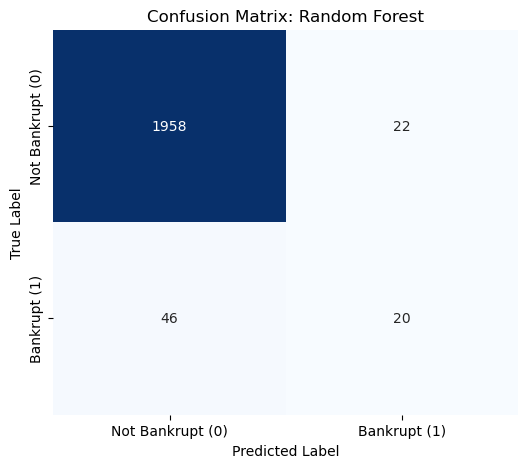

In [18]:
# Plot a confusion matrix to visualize how well the model classified each class
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Bankrupt (0)', 'Bankrupt (1)'],
            yticklabels=['Not Bankrupt (0)', 'Bankrupt (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Random Forest')
plt.show()

We can see from our Confusion Matrix that we were able to almost entirely accurately predicite all of the bankrupt and not bankrupt companies.

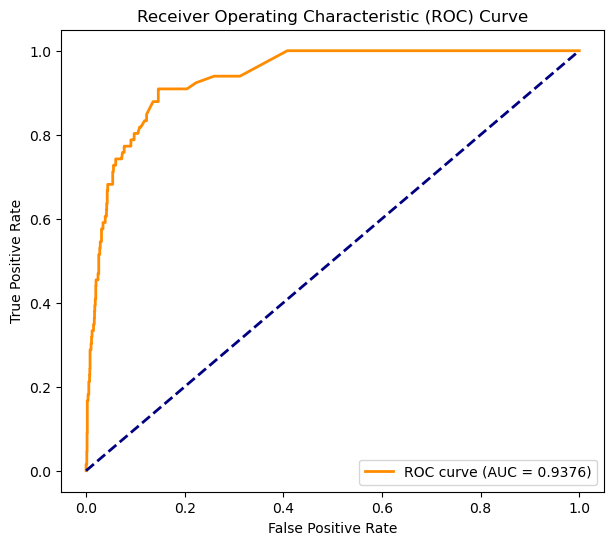


Final ROC AUC Score on Test Set: 0.9376


In [19]:
# Plot the ROC curve to evaluate model performance across all classification thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_probability)
auc_score = roc_auc_score(y_test, y_probability)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"\nFinal ROC AUC Score on Test Set: {auc_score:.4f}")

Our final ROC AUC score of 0.9377 means our model does a decent job at distinguishing between bankrupt and non-bankrupt companies. Essentially, if we randomly pick one bankrupt company and one non-bankrupt company, our model will correctly rank the bankrupt company as higher risk about 93.7% of the time.  

From the graph, we can also see that our true positive rate increases a lot faster than our false positive rate, which shows that the model is able to correctly identify bankrupt companies without misclassifying too many non-bankrupt companies, indicating strong predictive performance and effective separation between the two classes.